In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

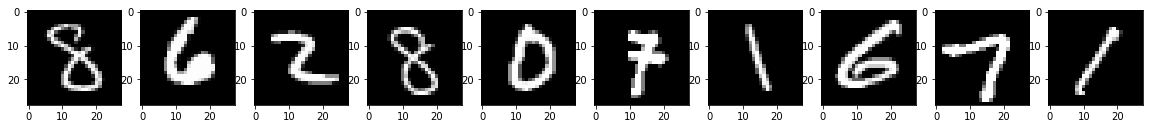

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [7]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # First layer: Conv2d -> LeakyReLU
        # Input Shape: (28, 28, 1)
        # Output Shape: (16, 16, 64)
        c1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c1')
        leaky_c1 = leakyReLU(c1, alpha)
        
        # Second layer: Conv2d -> BN -> LeakyReLU
        # Input Shape: (16, 16, 64)
        # Output Shape: (8, 8, 128)
        c2 = tf.layers.conv2d(inputs=leaky_c1, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c2')
        bc2 = tf.layers.batch_normalization(c2, training=True)
        leaky_c2 = leakyReLU(bc2, alpha)

        flatten = tf.layers.flatten(leaky_c2, name='flatten')

        # Dense.
        fully1 = tf.layers.dense(flatten, 1024, activation=None)
        bn_fully1 = tf.layers.batch_normalization(fully1, training=True)
        leaky_fully1 = leakyReLU(bn_fully1, alpha)
        
        # Dense
        logits = tf.layers.dense(leaky_fully1, 1, activation=None)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [8]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully
        fully1 = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        bn_fully1 = tf.layers.batch_normalization(fully1, training=is_train)
        leaky_bfc1 = leakyReLU(bn_fully1, alpha)
        
        # Fully
        fully2 = tf.layers.dense(inputs=leaky_bfc1, units=128*7*7, activation=None)
        bn_fully2 = tf.layers.batch_normalization(fully2, training=is_train)
        leaky_bfc2 = leakyReLU(bn_fully2, alpha)
        
        fc_reshape = tf.reshape(leaky_bfc2, (-1, 7, 7, 128))
        
        # Conv
        c1 = tf.layers.conv2d_transpose(inputs=fc_reshape, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c1')
        bc1 = tf.layers.batch_normalization(c1, training=is_train)
        leaky_c1 = leakyReLU(bc1, alpha)
        
        # Conv
        c2 = tf.layers.conv2d_transpose(inputs=leaky_c1, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c2')
        bc2 = tf.layers.batch_normalization(c2, training=is_train)
        leaky_c2 = leakyReLU(bc2, alpha)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=leaky_c2, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), 
                                            padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                                            name='logits')
        output = tf.nn.sigmoid(logits, name='output')
        
        return output

In [9]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [10]:
# Defining new cost function according to WGAN.
# Loss(Lpr, Lpg) = Max-w ( Ex~pr[fw(x)] - Ez~pg(z)[fw(Gtheta(z))] )  

# Generator would want to find the theta parameters that minimizes the cost of moving the distributions.
# Discriminator/Critic wants to find the w parameters that approximate better the Wassertein distance. Find maximum 
# of the moving the distribution Pg to Pr.


def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    loss_dis_real = tf.reduce_mean(logits_real)
    loss_dis_fake = tf.reduce_mean(logits_fake)
    loss_dis = -(loss_dis_real - loss_dis_fake)

    # Generator loss.
    # This is where we implement -log[D(G(z))] instead log[1-D(G(z))].
    # Recall the implementation of cross-entropy, sign already in. 
    loss_gen = -loss_dis_fake
    
    return loss_dis, loss_gen

#### Defining new cost function according to WGAN. 
Loss(Lpr, Lpg) = Max-w ( Ex~pr[fw(x)] - Ez~pg(z)[fw(Gtheta(z))] )  
Generator would want to find the theta parameters that minimizes the cost of moving the distributions.
Discriminator/Critic wants to find the w parameters that approximate better the Wassertein distance. Find maximum 
of the moving the distribution Pg to Pr.

In [16]:
def optimization(loss_dis, loss_gen, learning_rate, c):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if 'generator' in variable.name]
    discriminator_variables = [variable for variable in trainable_variables if 'discriminator' in variable.name]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        RMS_optimizer_dis = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
        train_discriminator = RMS_optimizer_dis.minimize(loss_dis , var_list=discriminator_variables)
        
        # Weight Clipping on Discriminator, this is done to ensure the Lipschitz constrain.
        dis_weight_clipping = [value.assign(tf.clip_by_value(value, -c, c)) for value in discriminator_variables]
        
        train_discriminator = tf.group(*[train_discriminator, dis_weight_clipping])
        
        # Generator.
        RMS_optimizer_gen = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
        train_generator = RMS_optimizer_gen.minimize(loss_gen, var_list=generator_variables)
        
    return train_generator, train_discriminator

In [17]:
def train(epochs, batch_size, z_dim, learning_rate, dataset, image_type, alpha, n_critic, c):
    
    dataset_size, image_width, image_height, image_channels = dataset.data_shape
    
    inputs = model_inputs(image_width=image_width, image_height=image_height, image_channels=image_channels, z_dim=z_dim)
    real_images, z_input, learning_rate_input = inputs
    
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, c=c)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    losses = list()
    run_epochs = 0
    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    critic_iterations = 0
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches:
                
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                
                # Update critic and clip gradients.
                session.run(train_discriminator, feed_dict=feed_dict)
                critic_iterations += 1
                
                # Update generator after n_critic updates from discriminator.
                if n_critic == critic_iterations:
                    critic_iterations = 0
                    session.run(train_generator, feed_dict=feed_dict)
               
                # Print losses and Generate samples.
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % 
                          (epoch, epochs, np.round(epoch_loss_gen, 3), np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session, output_gen, n_images, z_input, image_type)
                run_epochs+=1


In [18]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 10
batch_size = 32
z_dim = 100
learning_rate = 1e-4
image_type = 'gray'
alpha = 0.2

# WGAN specific parameters
# Gradient clipping value and number of updates in critic per generator.
c = 0.1
n_critic = 5


with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, dataset, image_type, alpha, n_critic, c)

InternalError: Blas GEMM launch failed : a.shape=(32, 100), b.shape=(100, 1024), m=32, n=1024, k=100
	 [[node generator/dense/MatMul (defined at <ipython-input-8-282c9372cbdd>:6)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_z_input_0_2/_3, generator/dense/kernel/read)]]

Caused by op 'generator/dense/MatMul', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-dce87ebab920>", line 18, in <module>
    train(epochs, batch_size, z_dim, learning_rate, dataset, image_type, alpha, n_critic, c)
  File "<ipython-input-17-7ee067e8ac60>", line 8, in train
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
  File "<ipython-input-10-68402356bb80>", line 12, in loss
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
  File "<ipython-input-8-282c9372cbdd>", line 6, in generator
    fully1 = tf.layers.dense(inputs=z_input, units=1024, activation=None)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 184, in dense
    return layer.apply(inputs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 970, in call
    outputs = gen_math_ops.mat_mul(inputs, self.kernel)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(32, 100), b.shape=(100, 1024), m=32, n=1024, k=100
	 [[node generator/dense/MatMul (defined at <ipython-input-8-282c9372cbdd>:6)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_z_input_0_2/_3, generator/dense/kernel/read)]]
